# Historical Volatility & Risk-Return Measures
This notebook is dedicated to the computation and tracking of historical volatility over time purely with mathematical finance tools, including:
* Sharpe & Sortino Ratios
* Modigliani(M2) Ratio
* Max Drawdown
* Calmar Ratio

The case study will be on S&P AUST INDEX with its derivatives (Australian Securities Excahnge)


In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import datetime as dt
import numpy as np
import pandas as pd

from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

import yfinance as yfin # resolves the problem of the pdr
yfin.pdr_override()

import warnings
warnings.filterwarnings('ignore')

In [3]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime.now()

data = pdr.get_data_yahoo(['CBA.AX', 'NAB.AX', 'STO.AX', '^AXJO'],
                        start, end)
df = data.copy()
df.loc[:, 'Close']

[*********************100%***********************]  4 of 4 completed


,CBA.AX,NAB.AX,STO.AX,^AXJO
Date,,,,
2017-01-03,82.970001,31.059999,4.02,5733.200195
2017-01-04,83.610001,31.209999,4.05,5736.399902
2017-01-05,83.849998,31.490000,4.15,5753.299805
2017-01-06,84.129997,31.520000,4.13,5755.600098
2017-01-09,85.260002,32.060001,4.23,5807.399902
...,...,...,...,...
2023-05-03,98.290001,28.549999,6.97,7197.399902
2023-05-04,95.760002,26.719999,7.10,7193.100098
2023-05-05,96.129997,26.580000,7.16,7220.000000


## Plot Historical data and Histogram of Log Returns
Computation of Log returns with annualized volatility with daily standard deviation

In [4]:
differ = df.Close/df.Close.shift(1)
log_rtns = np.log(differ).dropna()
log_rtns

,CBA.AX,NAB.AX,STO.AX,^AXJO
Date,,,,
2017-01-04,0.007684,0.004818,0.007435,0.000558
2017-01-05,0.002866,0.008932,0.024391,0.002942
2017-01-06,0.003334,0.000952,-0.004831,0.000400
2017-01-09,0.013342,0.016987,0.023925,0.008960
2017-01-10,-0.005174,-0.012239,-0.016687,-0.008074
...,...,...,...,...
2023-05-03,-0.018247,-0.018738,-0.025497,-0.009679
2023-05-04,-0.026077,-0.066245,0.018480,-0.000598
2023-05-05,0.003856,-0.005253,0.008415,0.003733


In [5]:
daily_std = log_rtns.std()
annualized_volatility = 100 * daily_std * np.sqrt(252)   #252 stands for approx 252 trading days of the year
daily_std = pd.DataFrame(daily_std, columns=['Daily STD'])
annualized_volatility = pd.DataFrame(annualized_volatility, columns=['Annualized Vol(%)'])
tableau = pd.concat([daily_std, annualized_volatility], axis=1)
tableau

,Daily STD,Annualized Vol(%)
CBA.AX,0.014483,22.991605
NAB.AX,0.015217,24.156089
STO.AX,0.024123,38.293456
^AXJO,0.010194,16.183243


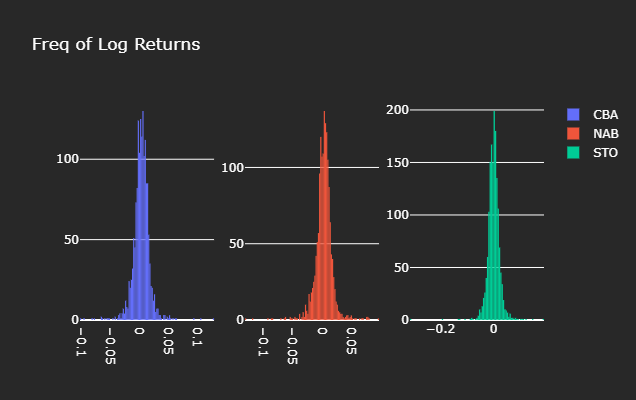

In [6]:
fig = make_subplots(rows=1, cols=3)
trace0 = go.Histogram(x=log_rtns['CBA.AX'], name='CBA')
trace1 = go.Histogram(x=log_rtns['NAB.AX'], name='NAB')
trace2 = go.Histogram(x=log_rtns['STO.AX'], name='STO')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

fig.update_layout(autosize=False, width=1200, height=400,
                  title='Freq of Log Returns',
                  plot_bgcolor='rgb(40, 40, 40)',
                  paper_bgcolor='rgb(40, 40, 40)',
                  font=dict(color='white'))

fig.show()

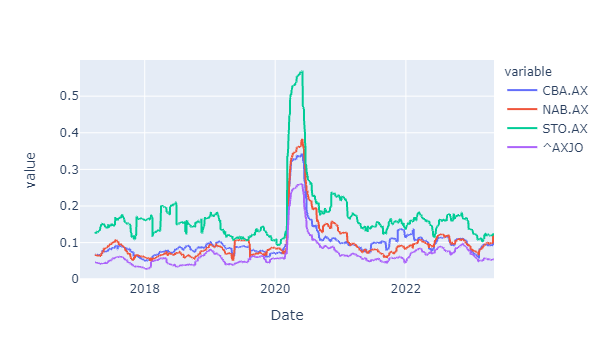

In [7]:
TRADE_DAYS = 60
volatility = log_rtns.rolling(window=TRADE_DAYS).std()*np.sqrt(TRADE_DAYS)
volatility.plot().update_layout(autosize=False, width=900, height=300)

## Sharpe & Sortino Ratios
* Sharpe Ratio is a measure for calculating risk-adjusted return. It is the average return earned in excess of the risk-free rate r per unit of volatility. It uses all the observations for calculating the std.
> $S_R = (R_p - R_f)/std_p$
* Sortino Ratio is similar to the Sharpe Ratio but it considers only the harmful variance instead of all observations.
> $S_R = (R_p - R_f)/std_d$

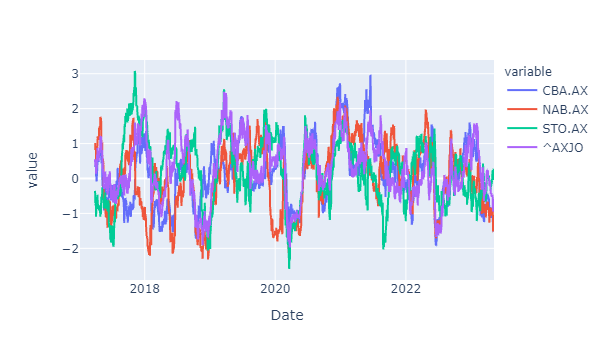

In [8]:
Rf = 0.01/252
Rp = log_rtns.rolling(window=TRADE_DAYS).mean()
Sharpe = (Rp - Rf) * TRADE_DAYS/volatility
Sharpe.plot().update_layout(autosize=False, width=900, height=300)

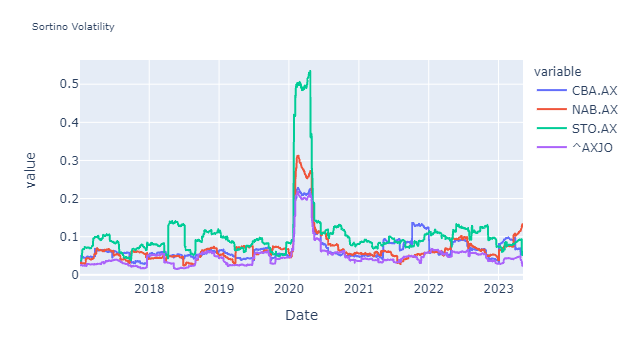

In [13]:
sortino_vol = log_rtns[log_rtns < 0].rolling(window=TRADE_DAYS, center=True, min_periods=10).std()*np.sqrt(TRADE_DAYS)
Sortino = (Rp - Rf) * TRADE_DAYS/sortino_vol
sortino_vol.plot().update_layout(title=dict(text="Sortino Volatility", font=dict(size=10), automargin=True, yref='paper'), autosize=False, width=900, height=300)

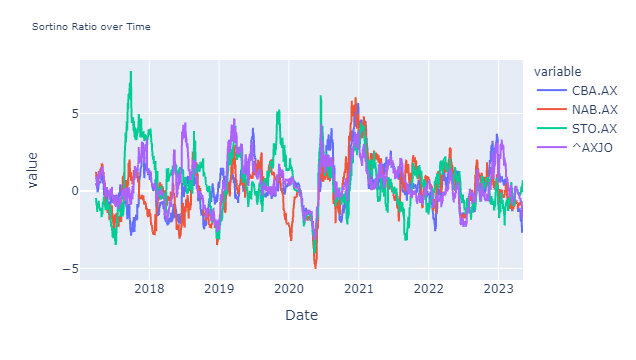

In [14]:
Sortino.plot().update_layout(title=dict(text="Sortino Ratio over Time", font=dict(size=10), automargin=True, yref='paper'), autosize=False, width=900, height=300)

## Modigliani(M2) Ratio 
This ratio measures the return of the portfolio adjusted for the risk of the portfolio relative to that of some benchmark.
> $M2 = Sharpe * std_b + R_f$

In [18]:
M2 = pd.DataFrame()
benchmark_vol = volatility['^AXJO']    # std_benchmark
for col in log_rtns.columns:
    if col != '^AXJO':
        M2[col] = (Sharpe[col] * benchmark_vol/TRADE_DAYS + Rf)* TRADE_DAYS
M2

,CBA.AX,NAB.AX,STO.AX
Date,,,
2017-01-04,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN
2017-01-09,NaN,NaN,NaN
2017-01-10,NaN,NaN,NaN
...,...,...,...
2023-05-03,-0.070179,-0.059430,0.000055
2023-05-04,-0.080470,-0.079520,0.006928
2023-05-05,-0.075934,-0.079821,0.008120


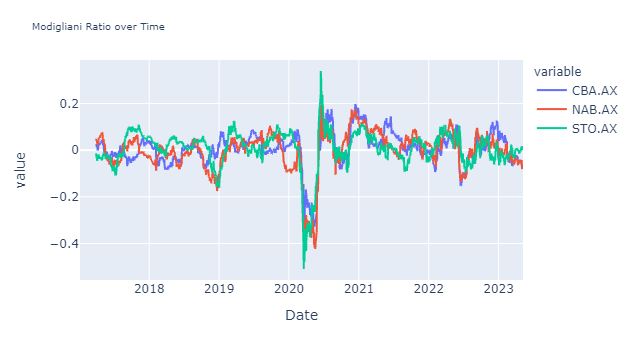

In [19]:
M2.plot().update_layout(title=dict(text=" Modigliani Ratio over Time", font=dict(size=10), automargin=True, yref='paper'), autosize=False, width=900, height=300)

## Max Drawdown 

This ratio qunatifies the steepest decline from peak to through observed for an investment. It doesn't rely on the underlying return being normally distributed
> $MDD(T) = (Peak-Lowest)/Peak$

In [23]:
def MDD(returns):
    cum_rtns = (1 + rtns).cumprod()
    peak = cum_rtns.expanding(min_periods=1).max()
    drawdown = (cum_rtns/peak) - 1
    return drawdown.min()

rtns = df.Close.pct_change().dropna()
mdd = rtns.apply(MDD, axis=0)
mdd * 100 # in %

,CBA.AX,NAB.AX,STO.AX,^AXJO
CBA.AX,-40.367074,-40.367074,-40.367074,-40.367074
NAB.AX,-59.284247,-59.284247,-59.284247,-59.284247
STO.AX,-69.444444,-69.444444,-69.444444,-69.444444
^AXJO,-36.530541,-36.530541,-36.530541,-36.530541


## Calmar Ratio
Calmar Ratio used MDD in the denominator as opposed to the STD
> $Calmar = (R_p - R_f)/mdd $

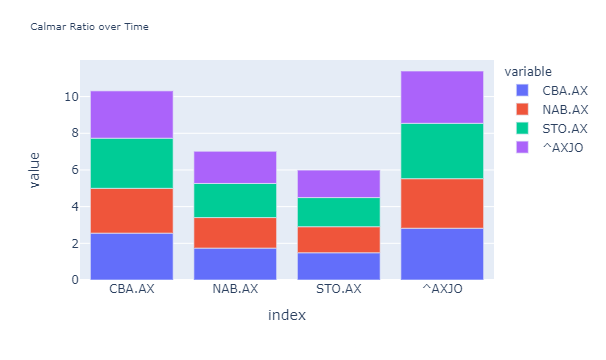

In [27]:
Calmar = np.exp(log_rtns.mean()*252)/abs(mdd)
Calmar.plot.bar().update_layout(title=dict(text=" Calmar Ratio over Time", font=dict(size=10), automargin=True, yref='paper'), autosize=False, width=900, height=300)